In [1]:
import numpy as np
import matplotlib
#allow for latex markup in matplotlib figures
matplotlib.rcParams['text.usetex'] = False
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap


#Import a few utility functions...
import sys  
from pathlib import Path
sys.path.insert(0, "../comm_channel")
sys.path.insert(0, "../polling_systems")
sys.path.insert(0, "../geometry")

#So we can import my local libs
import CommChannel as CC
import qos
import pointcloud as PC
import PollingSystem as PS
import MarkovianRP as MRP
import dtr

In [2]:
#setup quality of service requirements using reasonable values
F5GHz, F2_4GHz = 5, 2.4 #typical wifi frequencies are 2.4, 5, and sometiems 6 GHz
MOBILE_TX_POWER = qos.Pwr(20)#100-200mW (20-23 dBm) pretty typical, with 1W (30dBm) the absolute maximum
print(MOBILE_TX_POWER)
r = 6#any of 2, 4, 6, or 8
rx_noise = qos.Pwr(-85)#based on Yan and MostofiTWC13 #1e-10#
print(rx_noise)
BER = 1e-6
GAMMA_TH = qos.QoSReq(BER, r, rx_noise).thresholdChannelGain(MOBILE_TX_POWER)
print(GAMMA_TH)
print('SNR Threshold: %d'%(GAMMA_TH+MOBILE_TX_POWER.dBm - rx_noise.dBm))

20.000000 dBm	-10.000000 dBW	100.000000 mW	0.100000 W
-85.000000 dBm	-115.000000 dBW	0.000000 mW	0.000000 W
-77.90174759231485
SNR Threshold: 27


In [3]:
#Setup the system:

#For now, use same channel params, basd on the San Francisco measurements
nPL = 4.2  
kPL = -35

decorrSH = 3.09    
alpha = 8.41
sigmaSH = np.sqrt(alpha)
psdAtFC = 30

lam = 0.125
kRic = 10
decorrMP = 0.4*lam         
corrMP = 1
#sigmaMP = 3
sigmaMP = 1



#8 remote stations
qBase = np.array([[2,4],[2,22],
                 [12.5,4],[12.5,22],
                 [23,4],[23,22]])
cps = [CC.ChannelParams(qBase[i], nPL, kPL, sigmaSH, decorrSH, decorrMP, lam,
                      kRic, corrMP, psdAtFC, sigmaMP) for i in range(len(qBase))]

x_max = 25
x_min = 0
y_max = 25
y_min = 0
region = [x_max, x_min, y_max, y_min]

#res = 2/decorrMP
res = 10


In [ ]:
#Create Comm Channels
ccs = [CC.CommChannel(cps[i], region, res) for i in range(len(cps))]
for cc in ccs:
        cc.generateSH();cc.generateMP(2)

# #now display the regions so we know if this is going to work for us
color_array=['white', 'red', 'green', 'cyan']
#plot the connectivity fields
cfs = [cc.getConnectionField(GAMMA_TH) for cc in ccs]
r1 = 1*cfs[0]*cfs[1]; r2 = 1*cfs[2]*cfs[3]; r3 = 1*cfs[4]*cfs[5];
cmap = ListedColormap(color_array)
ticks =[0.75/2,1.5-0.75/2, 1.5+0.75/2, 3-0.75/2]
tick_labels = ['No Connectivity','X1', 'X2', 'X3']
CC.plotField(region, r1+r2+r3, 'Regions of Joint Connectivity', cmap=cmap,
             ticks=ticks, tick_labels = tick_labels, do_show=False)

for i in range(3):
    plt.scatter([qBase[2*i][0], qBase[2*i+1][0]], [qBase[2*i][1], qBase[2*i+1][1]],
                label='Group %d'%(i+1), marker='1', s=200)
plt.legend()    
plt.show()

In [4]:
#Create the predicted channel
pct_sample = 0.005
n_samples = int(pct_sample*(x_max - x_min)*(y_max - y_min)*res**2)
print('Drawing %d samples from each region'%(n_samples))
pcs = []
for cc in ccs:
    xs, vals = cc.sampleChannel(n_samples)
    pcs.append(CC.PredictedChannel(cc.cp, cc.region, res, xs, vals))
    print('Completed PredictedChannel %d'%(len(pcs)))
#avoid collisions when saving this off
pcs3 = pcs
%store pcs3

Drawing 312 samples from each region
Completed PredictedChannel 1
Completed PredictedChannel 2
Completed PredictedChannel 3
Completed PredictedChannel 4
Completed PredictedChannel 5
Completed PredictedChannel 6
Stored 'pcs3' (list)


In [4]:
%store -r pcs3
pcs = pcs3

In [5]:
#now display the regions so we know if this is going to work for us
color_array=['white', 'blue', 'red', 'green', 'cyan']
#plot the connectivity fields
pfs = [pc.getPConField(GAMMA_TH) for pc in pcs]

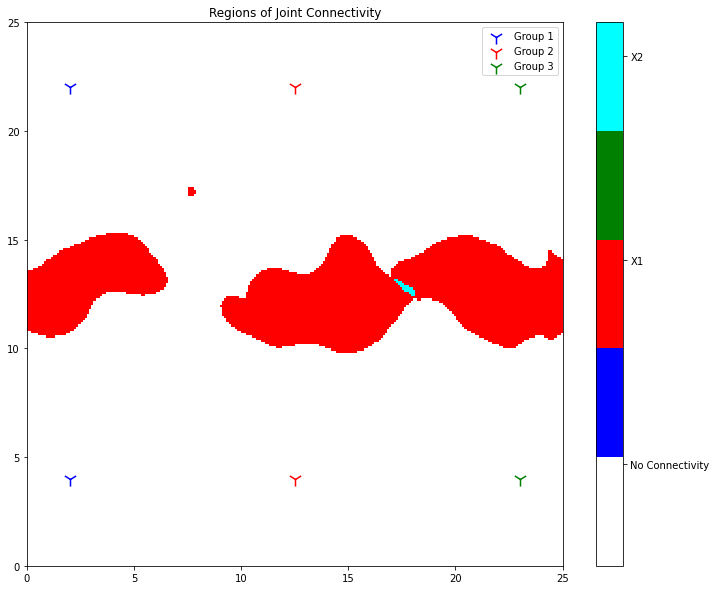

In [6]:
p_th = 0.7
for pc in pcs:
    pc.setPth(p_th)

r1 = 1*(pfs[0]*pfs[1]>p_th); r2 = 1*(pfs[2]*pfs[3]>p_th); r3 = 1*(pfs[4]*pfs[5]>p_th);
cmap = ListedColormap(color_array)
ticks =[0.75/2,1.5-0.75/2, 1.5+0.75/2, 3-0.75/2]
tick_labels = ['No Connectivity','X1', 'X2', 'X3']
CC.plotField(region, r1+r2+r3, 'Regions of Joint Connectivity', cmap=cmap,
             ticks=ticks, tick_labels = tick_labels, do_show=False)

for i in range(3):
    plt.scatter([qBase[2*i][0], qBase[2*i+1][0]], [qBase[2*i][1], qBase[2*i+1][1]],
                label='Group %d'%(i+1), color=color_array[i+1], marker='1', s=200)
plt.legend()    
plt.show()

In [7]:
from importlib import reload 
reload(dtr)
# reload(MRP)
# reload(PS)
reload(PC)

<module 'pointcloud' from '/home/win/dev/CommMotionPlanning/python/touring_relay/../geometry/pointcloud.py'>

In [8]:
bandwidth = 2#leave bandwidth in MHz*1000000#give ourselfes 2MHz of BW
beta = 1/(r*bandwidth)

p3 = [0.2, 0.1, 0.02]
pis = []
Xs = []
Ws =[]

#Naive Variables
npis = []
nXs = []
nWs =[]

#
all_els = []

els = np.ones(len(pcs)//2)/(beta*len(pcs))
sys = dtr.DTR(pcs, els, beta, th=GAMMA_TH)
for i in range(len(p3)):
    #make it easy to ensure stability by givein arrivals in terms of beta
    els = np.array([0.2/beta, 0.2/beta, p3[i]/beta])
    all_els.append(els)
    sys.ps.Ls = els
    W, pi, X = sys.optimize(x_opt_method=3, do_plot = False)
    pis.append(pi)
    Xs.append(X)
    Ws.append(W)
    nW, npi, nX = sys.naive_policy()
    npis.append(npi)
    nXs.append(nX)
    nWs.append(nW)
    print("============================================================")
    print("============================================================")
    print('Optimized:')
    print('\tPi: '+str(pi)+'\n\tRelay Positions: '+ str(X)+'\n\tWaiting Time: '+str(W))
    print('Naive:')
    print('\tPi: '+str(npi)+'\n\tRelay Positions: '+ str(nX)+'\n\tWaiting Time: '+str(nW))
    print("============================================================")
    print("============================================================")

Extracted edges...
Polygons constructed, looking for holes...
Constructed 1 possibly non-convex polygons
7 total subregions
Extracted edges...
Polygons constructed, looking for holes...
Constructed 2 possibly non-convex polygons
10 total subregions
Extracted edges...
Polygons constructed, looking for holes...
Constructed 1 possibly non-convex polygons
11 total subregions
Optimized Policy Waiting Time: 45.7894
Academic license - for non-commercial use only - expires 2021-08-20
Using license file /home/win/gurobi.lic
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 1 physical cores, 1 logical processors, using up to 1 threads
Optimize a model with 155 rows, 37 columns and 456 nonzeros
Model fingerprint: 0x46287fed
Model has 3 quadratic constraints
Variable types: 9 continuous, 28 integer (28 binary)
Coefficient statistics:
  Matrix range     [9e-02, 1e+04]
  QMatrix range    [1e+00, 

*  479   127              54       0.3924625    0.06227  84.1%   5.2    0s
*  480   126              54       0.3924621    0.06227  84.1%   5.2    0s
*  869   182              53       0.3912166    0.11030  71.8%   4.4    1s
*  870   181              53       0.3912142    0.11030  71.8%   4.4    1s
*  873   180              52       0.3912132    0.11030  71.8%   4.4    1s
* 1356   239              64       0.3802672    0.26068  31.4%   4.3    1s
H 1881   168                       0.3428821    0.28052  18.2%   4.2    2s
* 1938   176              77       0.3373888    0.28052  16.9%   4.2    2s
* 2312   258              78       0.3335298    0.28782  13.7%   4.0    2s
* 2783   340              83       0.3320842    0.29587  10.9%   3.9    2s
* 3134   339              69       0.3277528    0.30129  8.07%   3.8    2s
* 3136   337              69       0.3277525    0.30129  8.07%   3.8    2s
H 3226   337                       0.3277498    0.30294  7.57%   3.8    3s
* 5379   399             

* 3478   371              59       0.0770248    0.04450  42.2%   5.0    3s
* 3560   372              52       0.0741298    0.04451  40.0%   5.0    3s
* 3599   387              57       0.0740769    0.04451  39.9%   5.0    3s
* 3603   387              58       0.0740755    0.04451  39.9%   5.0    3s
* 3704   399              63       0.0698424    0.04451  36.3%   4.9    3s
* 3705   398              63       0.0698424    0.04451  36.3%   4.9    3s
* 4143   457              50       0.0697898    0.04459  36.1%   4.8    3s
* 4546   314              61       0.0533640    0.04468  16.3%   4.7    4s
* 4548   314              62       0.0533640    0.04468  16.3%   4.7    4s
* 5693   390              65       0.0529061    0.04496  15.0%   4.6    4s
* 6232   413              64       0.0527442    0.04508  14.5%   4.5    4s
* 6380   428              76       0.0525870    0.04510  14.2%   4.5    4s
* 6389   435              83       0.0525862    0.04510  14.2%   4.5    4s
* 6390   434             

* 4633   420              78       0.0567162    0.04630  18.4%   4.6    2s
* 6246   476              74       0.0551388    0.04662  15.5%   4.6    3s
* 6538   511              91       0.0548966    0.04665  15.0%   4.6    3s
* 6540   509              90       0.0548962    0.04665  15.0%   4.5    3s
* 7167   533              73       0.0548590    0.04672  14.8%   4.5    4s
* 7173   531              74       0.0548353    0.04672  14.8%   4.5    4s
* 7559   530              82       0.0534752    0.04676  12.6%   4.5    4s
* 8716   552              64       0.0531724    0.04687  11.8%   4.5    4s
  9473   563 infeasible   54         0.05317    0.04693  11.7%   4.4    5s
*10138   577              88       0.0504350    0.04697  6.86%   4.4    5s
*15548   891              75       0.0504215    0.04719  6.42%   4.4    7s
*17528   983              76       0.0500427    0.04722  5.63%   4.4    7s
*17530   965              75       0.0499564    0.04722  5.47%   4.4    7s
*18727  1097             

* 7691   506              81       0.0515091    0.04434  13.9%   4.2    3s
* 7694   507              83       0.0515080    0.04434  13.9%   4.2    3s
* 7703   506              85       0.0515075    0.04434  13.9%   4.2    3s
* 7706   505              87       0.0515073    0.04434  13.9%   4.2    3s
* 7707   502              87       0.0515024    0.04434  13.9%   4.2    3s
* 7768   469              58       0.0511715    0.04435  13.3%   4.2    3s
* 7770   469              59       0.0511715    0.04435  13.3%   4.2    3s
*11538   791              97       0.0486096    0.04470  8.05%   4.2    4s
*13845   869              61       0.0483211    0.04483  7.23%   4.3    4s
 13982   874 infeasible   60         0.04832    0.04483  7.21%   4.3    5s
*16864  1019              79       0.0482975    0.04492  7.00%   4.3    5s
*16870   994              80       0.0482201    0.04492  6.85%   4.3    5s
*16873   991              80       0.0482043    0.04492  6.82%   4.3    5s
*16908   992             

* 3183   379              51       0.0770028    0.04820  37.4%   5.2    2s
* 3192   377              54       0.0767591    0.04820  37.2%   5.2    2s
* 3193   376              54       0.0767511    0.04820  37.2%   5.2    2s
* 3375   403              57       0.0750655    0.04826  35.7%   5.1    2s
* 3427   403              52       0.0750263    0.04828  35.6%   5.1    2s
* 3430   402              52       0.0750206    0.04828  35.6%   5.1    2s
* 3585   384              53       0.0691460    0.04831  30.1%   5.1    2s
* 3970   470              65       0.0656499    0.04838  26.3%   5.1    2s
* 3972   468              66       0.0656479    0.04838  26.3%   5.1    2s
* 5746   493              59       0.0636884    0.04881  23.4%   5.0    3s
* 5747   490              59       0.0636866    0.04881  23.4%   5.0    3s
* 5799   496              64       0.0631512    0.04882  22.7%   5.0    3s
* 6204   484              66       0.0594797    0.04889  17.8%   4.9    3s
* 6448   483             

* 5423   416              93       0.0751090    0.05876  21.8%   5.5    3s
* 5424   415              93       0.0751090    0.05876  21.8%   5.5    3s
* 5425   414              92       0.0751090    0.05876  21.8%   5.5    3s
* 5426   413              91       0.0751090    0.05876  21.8%   5.5    3s
* 5427   412              90       0.0751090    0.05876  21.8%   5.5    3s
* 5428   411              89       0.0751090    0.05876  21.8%   5.5    3s
* 5429   410              88       0.0751090    0.05876  21.8%   5.5    3s
* 5807   421              64       0.0741465    0.05882  20.7%   5.5    3s
* 6183   436              66       0.0698313    0.05884  15.7%   5.4    3s
* 7459   499              58       0.0692219    0.05902  14.7%   5.4    4s
* 7460   498              58       0.0691819    0.05902  14.7%   5.4    4s
* 8122   587              69       0.0688796    0.05909  14.2%   5.4    4s
* 8126   587              69       0.0688764    0.05909  14.2%   5.4    4s
* 8127   586             

* 4829   431              56       0.1005646    0.06379  36.6%   4.2    2s
* 5018   476              83       0.0998670    0.06387  36.0%   4.2    3s
* 5019   475              83       0.0998611    0.06387  36.0%   4.2    3s
* 5252   458              63       0.0892022    0.06403  28.2%   4.1    3s
* 5253   457              62       0.0891810    0.06403  28.2%   4.1    3s
* 5630   502              51       0.0886423    0.06422  27.6%   4.1    3s
* 6276   590              57       0.0884295    0.06439  27.2%   4.0    3s
* 6300   606              75       0.0884265    0.06439  27.2%   4.0    3s
* 7609   698              73       0.0874176    0.06477  25.9%   3.9    4s
* 8515   563              67       0.0770906    0.06500  15.7%   3.9    4s
  9862   628    0.06620   29   14    0.07709    0.06527  15.3%   3.9    5s
*10035   655              66       0.0769878    0.06531  15.2%   3.9    5s
*10038   653              66       0.0769357    0.06531  15.1%   3.9    5s
*11142   753             

H    0     0                       1.4857246    0.00007   100%     -    0s
     0     2    0.00007    0   17    1.48572    0.00007   100%     -    0s
H    8     8                       0.7441150    0.00007   100%  14.2    0s
*  135    68              52       0.3882346    0.00007   100%   5.8    0s
*  137    68              53       0.3882346    0.00007   100%   5.8    0s
*  140    67              54       0.3882346    0.00007   100%   5.6    0s
*  212    69              57       0.2949116    0.00061   100%   5.6    0s
*  219    70              59       0.2948372    0.00061   100%   5.5    0s
*  296    77              44       0.2393176    0.00176  99.3%   4.9    0s
*  297    76              43       0.2393103    0.00176  99.3%   4.9    0s
H  674   241                       0.1308807    0.02026  84.5%   5.0    1s
*  953   230              54       0.1154158    0.05640  51.1%   4.9    1s
* 1407   178              57       0.1053235    0.05673  46.1%   5.2    1s
* 1408   177             

     0     0    0.00000    0   14          -    0.00000      -     -    0s
     0     0    0.00000    0   12          -    0.00000      -     -    0s
     0     0    0.00000    0   14          -    0.00000      -     -    0s
     0     0    0.00000    0   15          -    0.00000      -     -    0s
     0     0    0.00000    0   12          -    0.00000      -     -    0s
H    0     0                      21.1898840    0.00000   100%     -    0s
H    0     0                      21.1565799    0.00000   100%     -    0s
     0     2    0.00000    0   12   21.15658    0.00000   100%     -    0s
*  340   178              74      21.1544833    4.22756  80.0%   6.7    0s
*  341   177              74      21.1541787    4.22756  80.0%   6.7    0s
*  343   177              74      21.1540879    4.22756  80.0%   6.7    0s
*  345   175              72      21.1539362    4.22756  80.0%   6.6    0s
H  458   188                      21.1539361    4.67385  77.9%   6.7    0s
*  566   166             

* 5084   121              69       1.3300712    1.32971  0.03%   4.9    3s

Cutting planes:
  PSD: 4

Explored 5736 nodes (26707 simplex iterations) in 3.85 seconds
Thread count was 1 (of 1 available processors)

Solution count 10: 1.33007 1.33007 1.33007 ... 1.33007

Optimal solution found (tolerance 1.00e-04)
Best objective 1.330071227590e+00, best bound 1.329939331057e+00, gap 0.0099%
Transition probabilities:  [0.21243894 0.66352035 0.12404071]
Points:  [[ 6.43383253 12.93533013]
 [ 9.11517307 12.11517307]
 [17.         13.3       ]]
Optimized Location Waiting Time: 18.4229
Optimized Location Waiting Time: 18.4229
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 1 physical cores, 1 logical processors, using up to 1 threads
Optimize a model with 155 rows, 37 columns and 456 nonzeros
Model fingerprint: 0x9d04c916
Model has 3 quadratic constraints
Variable types: 9 continuous, 28 

Presolved model has 15 bilinear constraint(s)
Variable types: 24 continuous, 28 integer (28 binary)

Root relaxation: objective 0.000000e+00, 40 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.00000    0   12          -    0.00000      -     -    0s
     0     0    0.00000    0   18          -    0.00000      -     -    0s
     0     0    0.00000    0   14          -    0.00000      -     -    0s
     0     0    0.00000    0   14          -    0.00000      -     -    0s
     0     0    0.00000    0   12          -    0.00000      -     -    0s
     0     0    0.00000    0   14          -    0.00000      -     -    0s
     0     0    0.00000    0   15          -    0.00000      -     -    0s
     0     0    0.00000    0   12          -    0.00000      -     -    0s
H    0     0                      21.1898840    0.00000   100%     -    0s
H  


Explored 2159 nodes (12982 simplex iterations) in 1.51 seconds
Thread count was 1 (of 1 available processors)

Solution count 10: 0.828624 0.828624 0.828624 ... 0.828765

Optimal solution found (tolerance 1.00e-04)
Best objective 8.286236924917e-01, best bound 8.285874714305e-01, gap 0.0044%
Transition probabilities:  [0.15839426 0.78049681 0.06110893]
Points:  [[ 6.40923575 12.83694299]
 [ 9.1        12.1       ]
 [17.         13.3       ]]
Optimized Location Waiting Time: 11.3883
Optimized Location Waiting Time: 11.3883
Changed value of parameter NonConvex to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 1 physical cores, 1 logical processors, using up to 1 threads
Optimize a model with 155 rows, 37 columns and 456 nonzeros
Model fingerprint: 0x319b3b1b
Model has 3 quadratic constraints
Variable types: 9 continuous, 28 integer (28 binary)
Coefficient statistics:
  Matrix range     [9e-02, 1e+04]
  QMatrix range    

* 3145    36              38       0.7086246    0.70523  0.48%   4.6    2s
* 3172    38              36       0.7083659    0.70546  0.41%   4.6    2s
* 3192    30              33       0.7072651    0.70548  0.25%   4.6    2s
* 3196    30              34       0.7072160    0.70548  0.25%   4.6    2s
* 3220    29              32       0.7071460    0.70553  0.23%   4.6    2s
* 3272    26              32       0.7071408    0.70611  0.15%   4.6    2s

Cutting planes:
  Implied bound: 8
  RLT: 3
  Relax-and-lift: 1
  PSD: 20

Explored 3290 nodes (15237 simplex iterations) in 2.24 seconds
Thread count was 1 (of 1 available processors)

Solution count 10: 0.707141 0.707146 0.707216 ... 0.709219

Optimal solution found (tolerance 1.00e-04)
Best objective 7.071407619681e-01, best bound 7.070813690174e-01, gap 0.0084%
Transition probabilities:  [0.21058836 0.75780529 0.03160635]
Points:  [[ 6.40171681 12.80686724]
 [ 9.1        12.1       ]
 [17.         13.3       ]]
Optimized Location Waiting T

In [9]:
for i in range(len(p3)):
    print("============================================================")
    print("============================================================")
    print('Arrival Rates: ' + str(all_els[i]))
    print('Routing Policy (pi)')
    print('\tOptimal: '+str(pis[i])+'\tNaive: ' + str(npis[i]))
    print('Waiting Time')
    print('\tOptimal: %.2f\tNaive: %.2f\tDifference: %.2f'%(Ws[i], nWs[i], nWs[i] - Ws[i]) )
    
print("============================================================")
print("============================================================")

Arrival Rates: [2.4 2.4 2.4]
Routing Policy (pi)
	Optimal: [0.00550917 0.4988571  0.49563373]	Naive: [0.33333333 0.33333333 0.33333333]
Waiting Time
	Optimal: 16.57	Naive: 28.42	Difference: 11.85
Arrival Rates: [2.4 2.4 1.2]
Routing Policy (pi)
	Optimal: [0.27659989 0.62865617 0.09474395]	Naive: [0.4 0.4 0.2]
Waiting Time
	Optimal: 17.67	Naive: 24.92	Difference: 7.25
Arrival Rates: [2.4  2.4  0.24]
Routing Policy (pi)
	Optimal: [0.21058836 0.75780529 0.03160635]	Naive: [0.47619048 0.47619048 0.04761905]
Waiting Time
	Optimal: 9.80	Naive: 22.44	Difference: 12.64


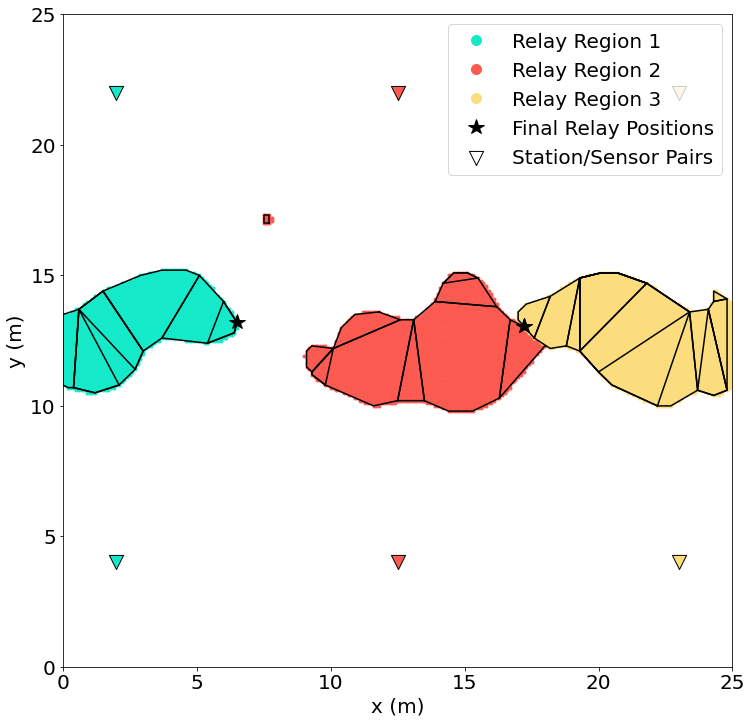

In [10]:
fs=20
plt.rcParams['font.size'] = fs
fig = plt.figure(figsize=(12,12))

#plot the connectivity fields
colors = ['xkcd:aqua', 'xkcd:coral', 'xkcd:wheat', 'c']
for i in range(sys.n):
    Xi = sys.Xis[i]
    pts = Xi['points']
    plt.plot(pts[:,0],  pts[:,1], '.', color=colors[i])
    #dummy series for better legend formatting
    plt.plot([-100], [-100], '.', color=colors[i], markersize=20, label='Relay Region %d'%(i+1))
    reg = sys.cregions[i]
    reg.plot_polys()


#plot base stations
for i in range(3):
    plt.scatter([qBase[2*i][0], qBase[2*i+1][0]], [qBase[2*i][1], qBase[2*i+1][1]],
                color=colors[i], marker='v', s=200, edgecolor='k')
#dummy series for legend formatting
plt.scatter([-100], [-100], marker='v', s=200, color='w', edgecolor='k', label='Station/Sensor Pairs')
pod_colors = []
x=Xs[0]
plt.plot(x[:,0], x[:,1], '*k', markersize=16, label='Final Relay Positions')
plt.xlim(region[1], region[0])
plt.ylim(region[3], region[2])
plt.xlabel('x (m)', fontsize=fs)
plt.ylabel('y (m)', fontsize=fs)

plt.legend(prop={'size':fs}, loc='upper right')
plt.savefig('sim_three_lines_%d_pth_%.2f_gammath_%d.png'%(sys.n, sys.p_th, sys.gamma_th),format='png')
plt.show()

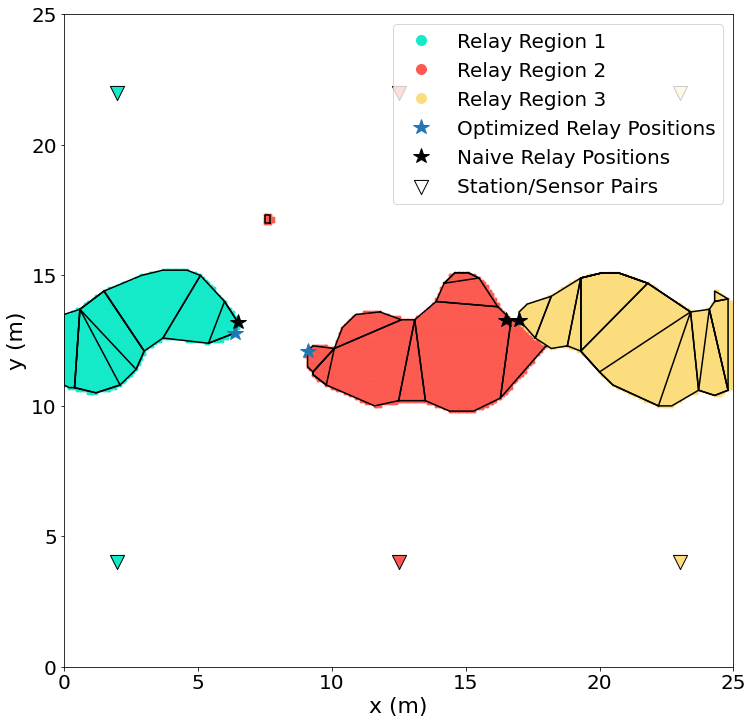

In [17]:
fs=20
plt.rcParams['font.size'] = fs
fig = plt.figure(figsize=(12,12))

#plot the connectivity fields
colors = ['xkcd:aqua', 'xkcd:coral', 'xkcd:wheat', 'c']
for i in range(sys.n):
    Xi = sys.Xis[i]
    pts = Xi['points']
    plt.plot(pts[:,0],  pts[:,1], '.', color=colors[i])
    #dummy series for better legend formatting
    plt.plot([-100], [-100], '.', color=colors[i], markersize=20, label='Relay Region %d'%(i+1))
    reg = sys.cregions[i]
    reg.plot_polys()


#plot base stations
for i in range(3):
    plt.scatter([qBase[2*i][0], qBase[2*i+1][0]], [qBase[2*i][1], qBase[2*i+1][1]],
                color=colors[i], marker='v', s=200, edgecolor='k')
#dummy series for legend formatting
plt.scatter([-100], [-100], marker='v', s=200, color='w', edgecolor='k', label='Station/Sensor Pairs')


x=Xs[2]
plt.plot(x[:,0], x[:,1], '*', markersize=16, label='Optimized Relay Positions')
x= nXs[2]
plt.plot(x[:,0], x[:,1], '*', markersize=16, color='k', label='Naive Relay Positions')
#for the legend
#plt.plot([-100], [100], '*', color='w', markeredgecolor='k', markersize=16, label='Final Relay Positions')
#ax = plt.gca()
#ax.annotate('')

plt.xlim(region[1], region[0])
plt.ylim(region[3], region[2])
plt.xlabel('x (m)', fontsize=22)
plt.ylabel('y (m)', fontsize=22)

plt.legend(prop={'size':fs}, loc='upper right')
plt.savefig('sim_three_lines_%d_pth_%.2f_gammath_%d_alt.png'%(sys.n, sys.p_th, sys.gamma_th),format='png')
plt.show()

In [18]:
#Now actually simulate the system
def MotionPower(k1, k2, v=1):
    return k1*v + k2

MOTION_POWER = MotionPower(7.5, 0.29)
ps = sys.ps
hrs = 1
minutes = hrs*60
seconds = minutes*60
#look at policy-invariant values
print("Average Data In/Out: " + str(ps.LSys()))
print("MB serviced in 1 hr: " + str(ps.LSys()*60*60))
AP = ps.RhoSys()*MOBILE_TX_POWER.W + (1-ps.RhoSys())*MOTION_POWER
print("Average Power (W): "+str(AP))
print("Energy Consumption Over 1 Hr (J): " + str(AP*60*60))

Average Data In/Out: 5.040000000000001
MB serviced in 1 hr: 18144.000000000004
Average Power (W): 4.560199999999999
Energy Consumption Over 1 Hr (J): 16416.719999999998


In [13]:
#simulate the optimized system
rp = MRP.RandomRP(pis[2])
S =  dtr.XtoS(Xs[2])
wait = ps.calc_avg_wait(rp, S)
print("Theoretical Wait Time: %.4f"%(wait))
#now run a bunch of simulations and look at the averages
FAWT = 0
TMB = 0
TE = 0
n_trials = 100
for i in range(n_trials):
    xt, wt, queues, total_travel_time = ps.simulate(rp, S, seconds)
    FAWT += wt[-1][1]
    MB_serviced = 0
    for q in queues:
        MB_serviced += len(q.wait_times)
    TMB += MB_serviced
    TE += MOTION_POWER*total_travel_time + MOBILE_TX_POWER.W*beta*MB_serviced
print("Average Empirical Wait Time (s): " + str(FAWT/n_trials))
print("MB serviced: " + str(TMB/n_trials))
print("Energy Consumption (J): " + str(TE/n_trials))

Theoretical Wait Time: 9.7954
Average Empirical Wait Time (s): 10.62024269663028
MB serviced: 18096.51
Energy Consumption (J): 16456.81812005828


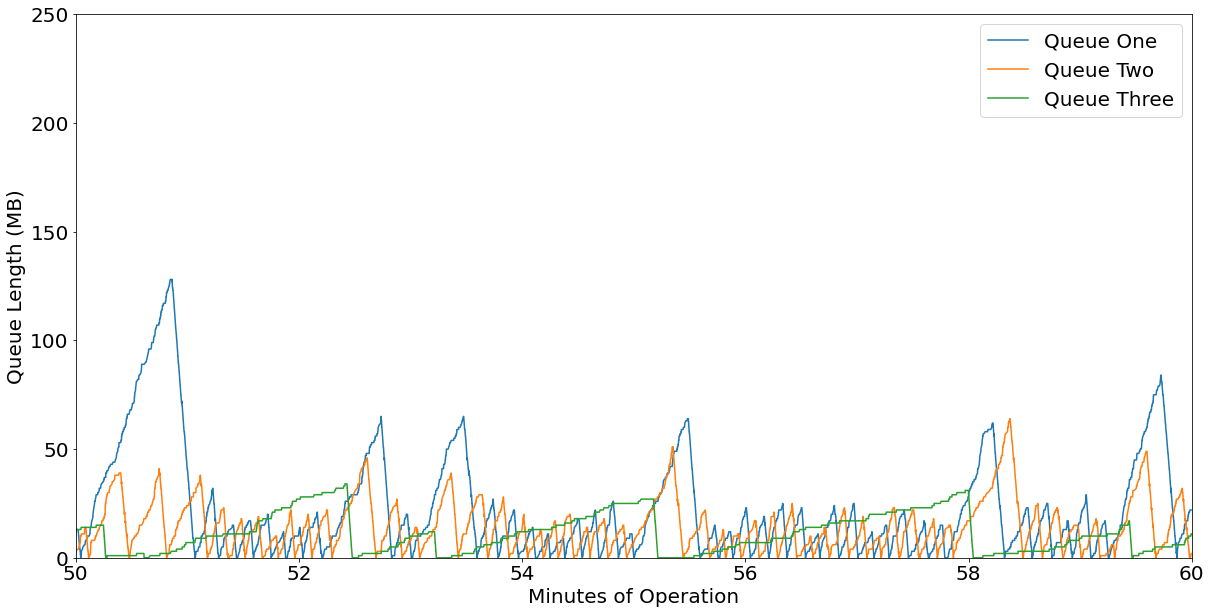

In [14]:
xt = np.array(xt)
fig = plt.figure(figsize=[20,10])
#plt.plot(xt[:,0], xt[:,1], label = 'Queue Servicing')
plt.plot(xt[:,0]/60, xt[:,2], label = 'Queue One')
plt.plot(xt[:,0]/60, xt[:,3], label = 'Queue Two')
plt.plot(xt[:,0]/60, xt[:,4], label = 'Queue Three')

plt.xlim(minutes-10,minutes)
plt.ylim(0,250)
plt.legend()
plt.xlabel('Minutes of Operation')
plt.ylabel('Queue Length (MB)')
plt.show()

In [15]:
#simulate the naive system
rp = MRP.RandomRP(npis[2])
S =  dtr.XtoS(nXs[2])
wait = ps.calc_avg_wait(rp, S)
print("Theoretical Wait Time: %.4f"%(wait))
#now run a bunch of simulations and look at the averages
FAWT = 0
TMB = 0
TE = 0
for i in range(n_trials):
    xt, wt, queues, total_travel_time = ps.simulate(rp, S, seconds)
    FAWT += wt[-1][1]
    MB_serviced = 0
    for q in queues:
        MB_serviced += len(q.wait_times)
    TMB += MB_serviced
    TE += MOTION_POWER*total_travel_time + MOBILE_TX_POWER.W*beta*MB_serviced
print("Average Empirical Wait Time (s): " + str(FAWT/n_trials))
print("MB serviced: " + str(TMB/n_trials))
print("Energy Consumption (J): " + str(TE/n_trials))

Theoretical Wait Time: 22.4375
Average Empirical Wait Time (s): 21.951022441329638
MB serviced: 18056.01
Energy Consumption (J): 16493.79953989136


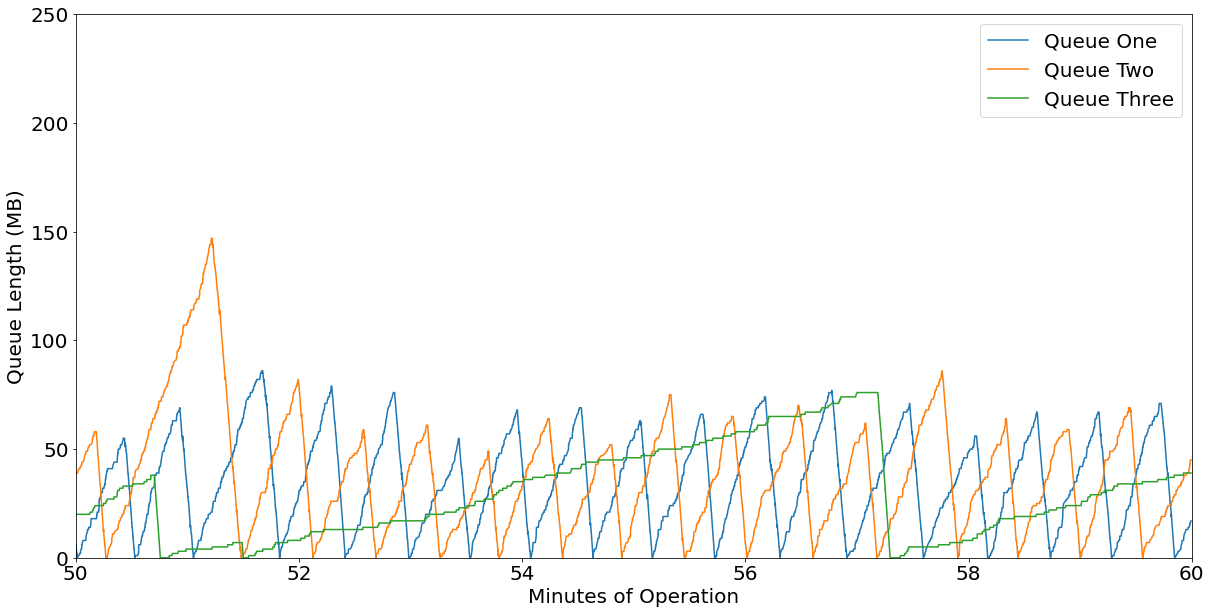

In [16]:
xt = np.array(xt)
fig = plt.figure(figsize=[20,10])
#plt.plot(xt[:,0], xt[:,1], label = 'Queue Servicing')
plt.plot(xt[:,0]/60, xt[:,2], label = 'Queue One')
plt.plot(xt[:,0]/60, xt[:,3], label = 'Queue Two')
plt.plot(xt[:,0]/60, xt[:,4], label = 'Queue Three')

plt.xlim(minutes-10,minutes)
plt.ylim(0,250)
plt.legend()
plt.xlabel('Minutes of Operation')
plt.ylabel('Queue Length (MB)')
plt.show()